In [2]:
using Random
using CairoMakie
using Turing, KernelFunctions, NNlib, SpecialFunctions
using StatsFuns: logistic, norminvcdf
using Memoization, ReverseDiff

## Periodic Activation

In [3]:
const triangleconst = π/(2*sqrt(2))
const preluconst = π/4
_trianglewave(x) = (x - π * floor(x/π + 0.5)) * (-1)^floor(x/π + 0.5)
_trianglewave(x::ReverseDiff.TrackedReal) = ReverseDiff.ForwardOptimize(heaviside)(x)

heaviside(x) = x < zero(x) ? zero(x) : x >= zero(x) ? one(x) : oftype(x, 0.5)
lsmatern(x, q, v, λ) = q*heaviside(x)*x^(ν - 1/2)*exp(-λ*x)
heaviside(x::ReverseDiff.TrackedReal) = ReverseDiff.ForwardOptimize(heaviside)(x)

heaviside (generic function with 2 methods)

In [4]:
abstract type PeriodicFunction end

hasBias(::PeriodicFunction) = true

struct SinActivation <: PeriodicFunction end
const sineconst = sqrt(2)
(σ::SinActivation)(x::T) where T = T(sineconst) * sin(x)

struct SinCosActivation <: PeriodicFunction end
(σ::SinCosActivation)(x) = sin(x) + cos(x)
hasBias(::SinCosActivation) = false

struct TriangleWave <: PeriodicFunction end
(σ::TriangleWave)(x) = triangleconst * _trianglewave(x)

struct PeriodicReLU <: PeriodicFunction end
(σ::PeriodicReLU)(x) = preluconst * (_trianglewave(x) + _trianglewave(x + π/2))

In [5]:
abstract type ActivationFunction end

struct RBF <: ActivationFunction
    σ::PeriodicFunction
end
(σ::RBF)(x) = σ.σ(x)
#mu0(:: RBF) =  
#sigma0(:: RBF) = 
prior_weights(::RBF) = Normal(mu0, sigma0)
prior_bias(::RBF) = Uniform(-π, π)

struct Matern <: ActivationFunction
    σ::PeriodicFunction
    ν # smoothness
end
(σ::Matern)(x) = σ.σ(x)
prior_weights(σ::Matern) = σ.ν == 0.5 ? Cauchy() : TDist(2*σ.ν)
prior_bias(::Matern) = Uniform(-π, π)

prior_bias (generic function with 2 methods)

# Visualizations

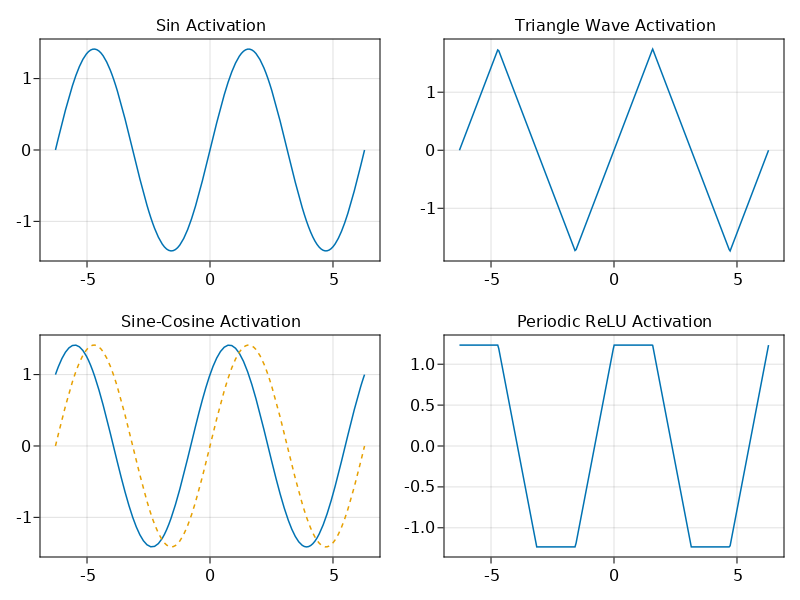

In [6]:
fig = Figure()

ax1 = fig[1, 1] = Axis(fig, title="Sin Activation")
lines!(ax1, -2*π..2*π, x -> SinActivation()(x))

ax2 = fig[2, 1] = Axis(fig, title="Sine-Cosine Activation")
lines!(ax2, -2*π..2*π, x -> SinCosActivation()(x))
lines!(ax2, -2*π..2*π, x -> SinActivation()(x), linestyle= :dash)

ax3 = fig[1, 2] = Axis(fig, title="Triangle Wave Activation")
lines!(ax3, -2*π..2*π, x -> TriangleWave()(x))

ax4 = fig[2, 2] = Axis(fig, title="Periodic ReLU Activation")
lines!(ax4, -2*π..2*π, x -> PeriodicReLU()(x))

fig

# Covariance

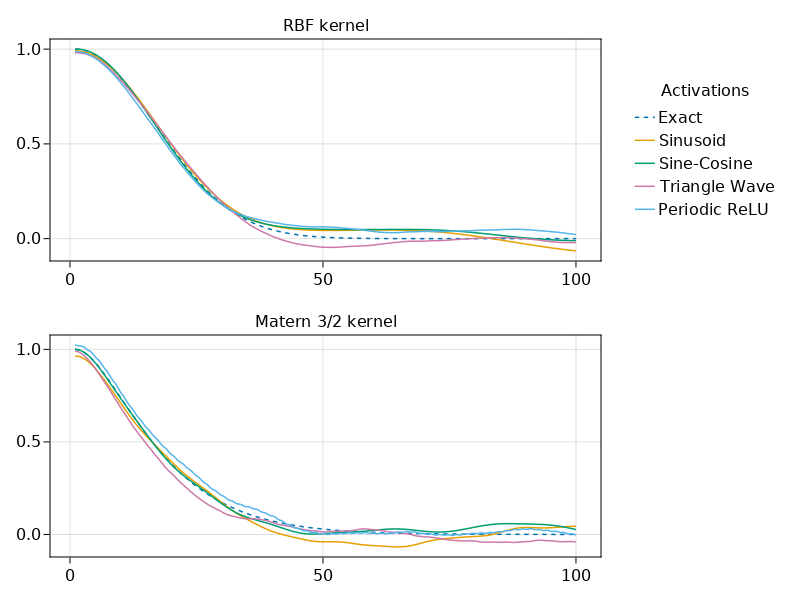

In [7]:
#clipped activation function
#perturbed prior
#periodic optimization
#shifted periodic activation

function K(x, y, afun; samples = 1000)
    b = hasBias(afun.σ) ? rand(prior_bias(afun), 1, samples) : 0.0
    w = rand(prior_weights(afun), samples)
    
    vec(mean(afun.(x * w' .+ b) .* afun.(y * w' .+ b), dims=2))
end

x = collect(range(0, 2*π, length=500))

fig=Figure()

ax1 = fig[1, 1] = Axis(fig, title = "RBF kernel")

k₁ = SqExponentialKernel()
K₁ = kernelmatrix(k₁, reshape(x, :, 1), obsdim=1)

lines!(ax1, 1..100, K₁[1, :], linestyle= :dash, label="Exact")
lines!(ax1, 1..100, K(x, x[1], RBF(SinActivation())), label="Sinusoid")
lines!(ax1, 1..100, K(x, x[1], RBF(SinCosActivation())), label="Sine-Cosine")
lines!(ax1, 1..100, K(x, x[1], RBF(TriangleWave())), label="Triangle Wave")
lines!(ax1, 1..100, K(x, x[1], RBF(PeriodicReLU())), label="Periodic ReLU")

ax2 = fig[2, 1] = Axis(fig, title= "Matern 3/2 kernel")

k₂ = Matern32Kernel()
K₂ = kernelmatrix(k₂, reshape(x, :, 1), obsdim=1)

lines!(ax2, 1..100, K₂[1, :], linestyle= :dash, label="Exact")
lines!(ax2, 1..100, K(x, x[1], Matern(SinActivation(), 3/2)), label="Sinusoid")
lines!(ax2, 1..100, K(x, x[1], Matern(SinCosActivation(), 3/2)), label="Sine-Cosine")
lines!(ax2, 1..100, K(x, x[1], Matern(TriangleWave(), 3/2)), label="Triangle Wave")
lines!(ax2, 1..100, K(x, x[1], Matern(PeriodicReLU(), 3/2)), label="Periodic ReLU")

fig[1, 2] = Legend(fig, ax1, "Activations", framevisible=false)

fig

In [8]:
x = collect(range(0, 2*π, length=50))
G₁ = mapreduce(xi -> K(x, xi, Matern(SinActivation(), 1/2)), hcat, x)
G₂ = mapreduce(xi -> K(x, xi, Matern(SinActivation(), 3/2)), hcat, x)
G₃ = mapreduce(xi -> K(x, xi, RBF(SinActivation())), hcat, x)

50×50 Matrix{Float64}:
  0.984854     0.968144      0.950491    …  0.00727493  0.014106   -0.0367742
  0.977856     0.978225      0.976424       0.00740258  0.0161967  -0.0407057
  0.955522     0.972222      0.986845       0.00805845  0.0171277  -0.0440965
  0.918718     0.950473      0.981364       0.00916822  0.0170517  -0.0466566
  0.868934     0.914138      0.960356       0.0106631   0.0161811  -0.0481802
  0.808183     0.865084      0.924926    …  0.0124814   0.0147805  -0.0485781
  0.738875     0.805721      0.876815       0.0145613   0.0131532  -0.0478924
  0.66367      0.738798      0.818255       0.016828    0.0116188  -0.0462906
  0.585312     0.667181      0.751812       0.0191781   0.0104863  -0.0440397
  0.506479     0.593642      0.680203       0.0214665   0.010023   -0.0414667
  0.429634     0.520676      0.606123    …  0.0235006   0.0104244  -0.0389102
  0.356907     0.450367      0.532089       0.0250452   0.0117894  -0.036674
  0.290004     0.384307      0.460316     

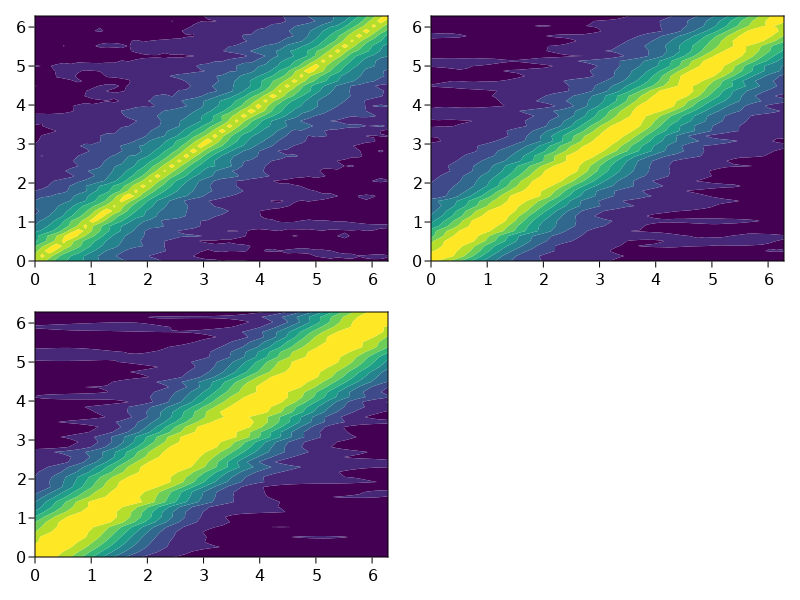

In [9]:
f = Figure()
ax1 = Axis(f[1, 1])
ax2 = Axis(f[1, 2])
ax3 = Axis(f[2, 1])

contourf!(ax1, x, x, G₁)
contourf!(ax2, x, x, G₂)
contourf!(ax3, x, x, G₃)

f

# Regression

In [10]:
N = 20
xs = (rand(N) * 2) .- 2
ys = exp.(abs.(xs))

ys .+= rand(N) * 0.1;
ys .-= mean(ys)
ys  /= var(ys)

20-element Vector{Float64}:
  0.832494223959317
  0.07777130516831252
 -0.5175715491450247
 -0.6262648807861612
 -0.6656455922916433
  0.25166504067499657
 -0.643653985552281
 -0.6854038373476004
 -0.26031350580488133
  0.05867289510371464
  0.017860918724568377
  0.06444592875984777
  0.4952203950773077
  0.89418200876527
 -0.20803253854763248
  0.5031888667238796
 -0.14342677936314582
  0.6850335713685374
  0.5624048828668101
 -0.6926273683541913

In [11]:
@model function bnn(x, y, afun, K)
    w ~ filldist(prior_weights(afun), 1, K)
    b ~ filldist(prior_bias(afun), 1, K)
    
    l ~ truncated(Normal(1, 5), 0, Inf)
    
    z = afun.(x * w * l .+ b)
    
    w0 ~ filldist(Normal(), K)
    b0 ~ Normal()
    
    f = (z * (w0 / sqrt(K)) .+ b0)
    Turing.@addlogprob! -sum(abs2(yj - fj) for (fj, yj) in zip(f, y))
end

bnn (generic function with 1 method)

In [12]:
Turing.setadbackend(:reversediff)
Turing.setrdcache(true);

In [15]:
function predict(xtest, afun, K, chain; burnin=1)
    w_names = filter(n -> contains(string(n), "w["), names(chain))
    w0_names = filter(n -> contains(string(n), "w0["), names(chain))
    b_names = filter(n -> contains(string(n), "b["), names(chain))
    
    w = chain[w_names]
    b = chain[b_names]
    w0 = chain[w0_names]
    b0 = chain["b0"]
    l = chain["l"]
    
    nsamples = length(w)
    
    latents = maps(s -> begin
           w_ = Array(w[s])
           b_ = Array(b[s])
            
           w0_ = vec(Array(w0[s]))
           b0_ = b0[s]
            
           l_ = l[s]
           
           z = afun.(xtest * w_ * l_ .+ b_)
           f = (z * (w0_ / sqrt(K)) .+ b0_)
            end, burnin:samples)
    
    err_0 = 1.96 * sqrt.(var(latents)) .+ 1
    err = 1.96 * std(latents)
    
    return mean(latents), err, err_0
end

predict (generic function with 1 method)

In [ ]:
model = bnn(xs, ys, Matern(PeriodicReLU(), 3/2), 10);
chain = sample(model, NUTS(1000, 0.8), 4000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /opt/julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling:  30%|████████████▎                            |  ETA: 1:37:04

In [ ]:
xt = collect(range(-4, 1, length=100))

yhat, σf, σ0 = predict(xt, Matern(PeriodicReLU(), 3/2), 10, chain);

f = Figure()
Axis(f[1, 1])

band!(xt, yhat + σf, yhat - σf)
band!(xt, yhat + σ0, yhat - σ0)
scatter!(xs, ys, color = :blue)
line!(xt, yhat, color = :red)

f